# Machine Learning Engineer Nanodegree
## Supervised Learning
## Project: Building a Student Intervention System

Welcome to the second project of the Machine Learning Engineer Nanodegree! In this notebook, some template code has already been provided for you, and it will be your job to implement the additional functionality necessary to successfully complete this project. Sections that begin with **'Implementation'** in the header indicate that the following block of code will require additional functionality which you must provide. Instructions will be provided for each section and the specifics of the implementation are marked in the code block with a `'TODO'` statement. Please be sure to read the instructions carefully!

In addition to implementing code, there will be questions that you must answer which relate to the project and your implementation. Each section where you will answer a question is preceded by a **'Question X'** header. Carefully read each question and provide thorough answers in the following text boxes that begin with **'Answer:'**. Your project submission will be evaluated based on your answers to each of the questions and the implementation you provide.  

>**Note:** Code and Markdown cells can be executed using the **Shift + Enter** keyboard shortcut. In addition, Markdown cells can be edited by typically double-clicking the cell to enter edit mode.

### Question 1 - Classification vs. Regression
*Your goal for this project is to identify students who might need early intervention before they fail to graduate. Which type of supervised learning problem is this, classification or regression? Why?*

**Answer: ** This is typically a classification problem as we are only targetting to classify students under one of the following two categories:

Category 1: [Clever Student] Student doesn't need intervention as he will probably successully pass without intervention

Category 2: [Lazy Student] Student require intervention as probably he will fail to pass if no intervention too place

## Exploring the Data
Run the code cell below to load necessary Python libraries and load the student data. Note that the last column from this dataset, `'passed'`, will be our target label (whether the student graduated or didn't graduate). All other columns are features about each student.

In [14]:
# Import libraries
import numpy as np
import pandas as pd
from time import time
from sklearn.metrics import f1_score

# Read student data
student_data = pd.read_csv("student-data.csv")
print "Student data read successfully!"

Student data read successfully!


### Implementation: Data Exploration
Let's begin by investigating the dataset to determine how many students we have information on, and learn about the graduation rate among these students. In the code cell below, you will need to compute the following:
- The total number of students, `n_students`.
- The total number of features for each student, `n_features`.
- The number of those students who passed, `n_passed`.
- The number of those students who failed, `n_failed`.
- The graduation rate of the class, `grad_rate`, in percent (%).


In [15]:
# TODO: Calculate number of students
n_students = len(student_data)

# TODO: Calculate number of features
n_features = len(student_data.columns[:-1])

# TODO: Calculate passing students
n_passed = len(student_data[student_data.passed == 'yes'])

# TODO: Calculate failing students
n_failed = len(student_data[student_data.passed == 'no'])

# TODO: Calculate graduation rate
grad_rate = n_passed * 100. / (n_passed + n_failed)

# Print the results
print "Total number of students: {}".format(n_students)
print "Number of features: {}".format(n_features)
print "Number of students who passed: {}".format(n_passed)
print "Number of students who failed: {}".format(n_failed)
print "Graduation rate of the class: {:.2f}%".format(grad_rate)

Total number of students: 395
Number of features: 30
Number of students who passed: 265
Number of students who failed: 130
Graduation rate of the class: 67.09%


## Preparing the Data
In this section, we will prepare the data for modeling, training and testing.

### Identify feature and target columns
It is often the case that the data you obtain contains non-numeric features. This can be a problem, as most machine learning algorithms expect numeric data to perform computations with.

Run the code cell below to separate the student data into feature and target columns to see if any features are non-numeric.

In [16]:
# Extract feature columns
feature_cols = list(student_data.columns[:-1])

# Extract target column 'passed'
target_col = student_data.columns[-1] 

# Show the list of columns
print "Feature columns:\n{}".format(feature_cols)
print "\nTarget column: {}".format(target_col)

# Separate the data into feature data and target data (X_all and y_all, respectively)
X_all = student_data[feature_cols]
y_all = student_data[target_col]

# Show the feature information by printing the first five rows
print "\nFeature values:"
print X_all.head()

Feature columns:
['school', 'sex', 'age', 'address', 'famsize', 'Pstatus', 'Medu', 'Fedu', 'Mjob', 'Fjob', 'reason', 'guardian', 'traveltime', 'studytime', 'failures', 'schoolsup', 'famsup', 'paid', 'activities', 'nursery', 'higher', 'internet', 'romantic', 'famrel', 'freetime', 'goout', 'Dalc', 'Walc', 'health', 'absences']

Target column: passed

Feature values:
  school sex  age address famsize Pstatus  Medu  Fedu     Mjob      Fjob  \
0     GP   F   18       U     GT3       A     4     4  at_home   teacher   
1     GP   F   17       U     GT3       T     1     1  at_home     other   
2     GP   F   15       U     LE3       T     1     1  at_home     other   
3     GP   F   15       U     GT3       T     4     2   health  services   
4     GP   F   16       U     GT3       T     3     3    other     other   

    ...    higher internet  romantic  famrel  freetime goout Dalc Walc health  \
0   ...       yes       no        no       4         3     4    1    1      3   
1   ...       

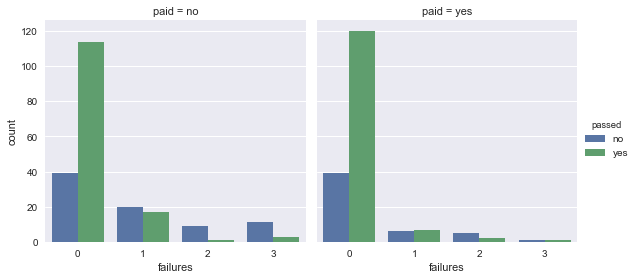

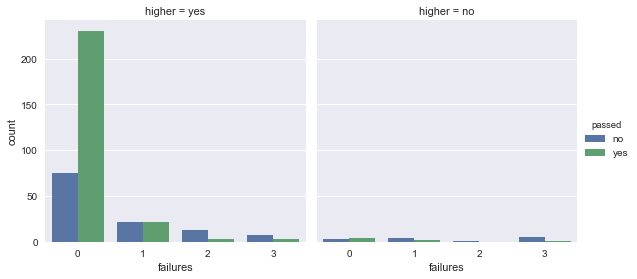

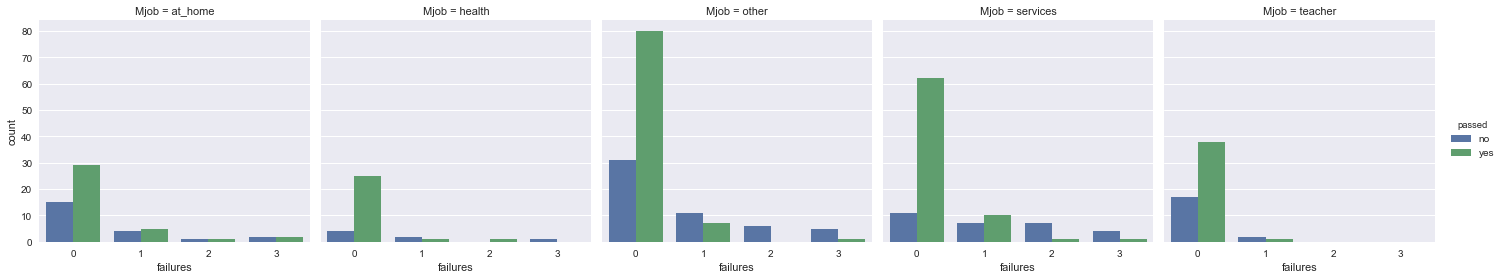

In [17]:
# Exploring Data structure visually

%matplotlib inline
import seaborn as sns
sns.factorplot("failures", col="paid", data=student_data, hue='passed', kind="count");
sns.factorplot("failures", col="higher", data=student_data, hue='passed', kind="count");
sns.factorplot("failures", col="Mjob", data=student_data, hue='passed', kind="count");

# It is clear from the below graphs that when the male is at home or working in health care, the number of failures is less than if he is working in another job since he is having enough time for his children.

### Preprocess Feature Columns

As you can see, there are several non-numeric columns that need to be converted! Many of them are simply `yes`/`no`, e.g. `internet`. These can be reasonably converted into `1`/`0` (binary) values.

Other columns, like `Mjob` and `Fjob`, have more than two values, and are known as _categorical variables_. The recommended way to handle such a column is to create as many columns as possible values (e.g. `Fjob_teacher`, `Fjob_other`, `Fjob_services`, etc.), and assign a `1` to one of them and `0` to all others.

These generated columns are sometimes called _dummy variables_, and we will use the [`pandas.get_dummies()`](http://pandas.pydata.org/pandas-docs/stable/generated/pandas.get_dummies.html?highlight=get_dummies#pandas.get_dummies) function to perform this transformation. Run the code cell below to perform the preprocessing routine discussed in this section.

In [18]:
def preprocess_features(X):
    ''' Preprocesses the student data and converts non-numeric binary variables into
        binary (0/1) variables. Converts categorical variables into dummy variables. '''
    
    # Initialize new output DataFrame
    output = pd.DataFrame(index = X.index)

    # Investigate each feature column for the data
    for col, col_data in X.iteritems():
        
        # If data type is non-numeric, replace all yes/no values with 1/0
        if col_data.dtype == object:
            col_data = col_data.replace(['yes', 'no'], [1, 0])
            print "=> col_data type: {}  {}".format(col, col_data)
            
        if col_data.dtype == object:
            # Example: 'school' => 'school_GP' and 'school_MS'
            col_data = pd.get_dummies(col_data, prefix = col)  
            print "==> col_data type: {}  {}".format(col, col_data)
        
        # Collect the revised columns
        output = output.join(col_data)
    
    return output

X_all = preprocess_features(X_all)
print "Processed feature columns ({} total features):\n{}".format(len(X_all.columns), list(X_all.columns))

# print X_all.head()

=> col_data type: school  0      GP
1      GP
2      GP
3      GP
4      GP
5      GP
6      GP
7      GP
8      GP
9      GP
10     GP
11     GP
12     GP
13     GP
14     GP
15     GP
16     GP
17     GP
18     GP
19     GP
20     GP
21     GP
22     GP
23     GP
24     GP
25     GP
26     GP
27     GP
28     GP
29     GP
       ..
365    MS
366    MS
367    MS
368    MS
369    MS
370    MS
371    MS
372    MS
373    MS
374    MS
375    MS
376    MS
377    MS
378    MS
379    MS
380    MS
381    MS
382    MS
383    MS
384    MS
385    MS
386    MS
387    MS
388    MS
389    MS
390    MS
391    MS
392    MS
393    MS
394    MS
Name: school, dtype: object
==> col_data type: school       school_GP  school_MS
0            1          0
1            1          0
2            1          0
3            1          0
4            1          0
5            1          0
6            1          0
7            1          0
8            1          0
9            1          0
10           1         

### Implementation: Training and Testing Data Split
So far, we have converted all _categorical_ features into numeric values. For the next step, we split the data (both features and corresponding labels) into training and test sets. In the following code cell below, you will need to implement the following:
- Randomly shuffle and split the data (`X_all`, `y_all`) into training and testing subsets.
  - Use 300 training points (approximately 75%) and 95 testing points (approximately 25%).
  - Set a `random_state` for the function(s) you use, if provided.
  - Store the results in `X_train`, `X_test`, `y_train`, and `y_test`.

In [19]:
# TODO: Import any additional functionality you may need here
from sklearn import cross_validation

# TODO: Set the number of training points
num_train = 300

# Set the number of testing points
num_test = X_all.shape[0] - num_train

# TODO: Shuffle and split the dataset into the number of training and testing points above
# X_train = None
# X_test = None
# y_train = None
# y_test = None

X_train, X_test, y_train, y_test = cross_validation.train_test_split(X_all, y_all, stratify=y_all, test_size=num_test, random_state=30)

# Show the results of the split
print "Training set has {} samples.".format(X_train.shape[0])
print "Testing set has {} samples.".format(X_test.shape[0])

Training set has 300 samples.
Testing set has 95 samples.


In [20]:
print "Train set 'yes' pct = {:.2f}%".format(100 * (y_train == 'yes').mean())
print "Test  set 'yes' pct = {:.2f}%".format(100 * (y_test == 'yes').mean())

Train set 'yes' pct = 67.00%
Test  set 'yes' pct = 67.37%


## Training and Evaluating Models
In this section, you will choose 3 supervised learning models that are appropriate for this problem and available in `scikit-learn`. You will first discuss the reasoning behind choosing these three models by considering what you know about the data and each model's strengths and weaknesses. You will then fit the model to varying sizes of training data (100 data points, 200 data points, and 300 data points) and measure the F<sub>1</sub> score. You will need to produce three tables (one for each model) that shows the training set size, training time, prediction time, F<sub>1</sub> score on the training set, and F<sub>1</sub> score on the testing set.

**The following supervised learning models are currently available in** [`scikit-learn`](http://scikit-learn.org/stable/supervised_learning.html) **that you may choose from:**
- Gaussian Naive Bayes (GaussianNB)
- Decision Trees
- Ensemble Methods (Bagging, AdaBoost, Random Forest, Gradient Boosting)
- K-Nearest Neighbors (KNeighbors)
- Stochastic Gradient Descent (SGDC)
- Support Vector Machines (SVM)
- Logistic Regression

### Question 2 - Model Application
*List three supervised learning models that are appropriate for this problem. For each model chosen*
- Describe one real-world application in industry where the model can be applied. *(You may need to do a small bit of research for this — give references!)* 
- What are the strengths of the model; when does it perform well? 
- What are the weaknesses of the model; when does it perform poorly?
- What makes this model a good candidate for the problem, given what you know about the data?

**Answer: ** According to the scikit-learn algorithm cheat sheet, for a classification algorithm and for samples whose count is less than 100K samples, we should start by Linear SVM.SVC and then KNN and then Ensemble Classifiers. In the following, we will analyze the strengths and weaknesses of each model.

1. SVM (SVC)
[Source: "https://www.analyticsvidhya.com/blog/2015/10/understaing-support-vector-machine-example-code/"]

1.1. Application: SVM is widely used in the classification of images and in hand-written characters recognition

1.2. Strengths: SVM has a clear margin of separation, is effective in higher dimensions space of features and is memory efficient since it uses a subset of training points in the decision function.

1.3. Weaknesses: It also doesn’t perform very well, when the data set has more noise i.e. target classes are overlapping. In addition, It doesn’t perform well, when we have large data set because the required training time is higher

1.4. Why it is a good candidate: Given that the number of samples is not huge and given that we have a considerable amount of features then we should be able to benefit from this algorithm

2. K-Nearest Neighbors KNN
[Source: "https://saravananthirumuruganathan.wordpress.com/2010/05/17/a-detailed-introduction-to-k-nearest-neighbor-knn-algorithm/"]

2.1. Application: It is surprisingly versatile and its applications range from vision to proteins to computational geometry to graphs and so on 

2.2. Strengths: There is practically no training required (known as a lazy algorithm)

2.3. Weaknesses: We will need more memory than the other classifiers as we always have to refer to all samples during predictions. In addition, Testing is very costly in terms of time.

2.4. Why it is a good candidate: we don't have a huge number of samples and therefore the available memory is fine for testing and prediction

3. Ensemble Classifiers
[Source: "https://en.wikipedia.org/wiki/Ensembles_of_classifiers"]

3.1. Application: The most known application of ensemble classifiers is the Netflix challenge recommender system. Other examples include malware Intrusion detection, Banking, credit risk, fraud detection, Coronary diseases, …

3.2. Strengths: Achieves very high boost in accuracy as it improves underlying models

2.3. Weaknesses: Requires increased storage, computation and decreased comprehensibility

3.4. Why it is a good candidate: Due to the expected boost in accuracy the I am looking forward to test the perforamnce of the  Ensemble Classifier - Random Forest model

### Setup
Run the code cell below to initialize three helper functions which you can use for training and testing the three supervised learning models you've chosen above. The functions are as follows:
- `train_classifier` - takes as input a classifier and training data and fits the classifier to the data.
- `predict_labels` - takes as input a fit classifier, features, and a target labeling and makes predictions using the F<sub>1</sub> score.
- `train_predict` - takes as input a classifier, and the training and testing data, and performs `train_clasifier` and `predict_labels`.
 - This function will report the F<sub>1</sub> score for both the training and testing data separately.

In [21]:
def train_classifier(clf, X_train, y_train):
    ''' Fits a classifier to the training data. '''
    
    # Start the clock, train the classifier, then stop the clock
    start = time()
    clf.fit(X_train, y_train)
    end = time()
    
    # Print the results
    print "Trained model in {:.4f} seconds".format(end - start)

    
def predict_labels(clf, features, target):
    ''' Makes predictions using a fit classifier based on F1 score. '''
    
    # Start the clock, make predictions, then stop the clock
    start = time()
    y_pred = clf.predict(features)
    end = time()
    
    # Print and return results
    print "Made predictions in {:.4f} seconds.".format(end - start)
    return f1_score(target.values, y_pred, pos_label='yes')


def train_predict(clf, X_train, y_train, X_test, y_test):
    ''' Train and predict using a classifer based on F1 score. '''
    
    # Indicate the classifier and the training set size
    print "Training a {} using a training set size of {}. . .".format(clf.__class__.__name__, len(X_train))
    
    # Train the classifier
    train_classifier(clf, X_train, y_train)
    
    # Print the results of prediction for both training and testing
    print "F1 score for training set: {:.4f}.".format(predict_labels(clf, X_train, y_train))
    print "F1 score for test set: {:.4f}.".format(predict_labels(clf, X_test, y_test))

### Implementation: Model Performance Metrics
With the predefined functions above, you will now import the three supervised learning models of your choice and run the `train_predict` function for each one. Remember that you will need to train and predict on each classifier for three different training set sizes: 100, 200, and 300. Hence, you should expect to have 9 different outputs below — 3 for each model using the varying training set sizes. In the following code cell, you will need to implement the following:
- Import the three supervised learning models you've discussed in the previous section.
- Initialize the three models and store them in `clf_A`, `clf_B`, and `clf_C`.
 - Use a `random_state` for each model you use, if provided.
 - **Note:** Use the default settings for each model — you will tune one specific model in a later section.
- Create the different training set sizes to be used to train each model.
 - *Do not reshuffle and resplit the data! The new training points should be drawn from `X_train` and `y_train`.*
- Fit each model with each training set size and make predictions on the test set (9 in total).  
**Note:** Three tables are provided after the following code cell which can be used to store your results.

In [22]:
# TODO: Import the three supervised learning models from sklearn
from sklearn.svm import SVC
from sklearn.neighbors import KNeighborsClassifier 
from sklearn.ensemble import RandomForestClassifier

# TODO: Initialize the three models
clf_A = SVC(random_state=30)
clf_B = KNeighborsClassifier()
clf_C = RandomForestClassifier(random_state=30)


# TODO: Set up the training set sizes
X_train_100 = X_train[0:100]
y_train_100 = y_train[0:100]

X_train_200 = X_train[0:200]
y_train_200 = y_train[0:200]

X_train_300 = X_train[0:300]
y_train_300 = y_train[0:300]

# TODO: Execute the 'train_predict' function for each classifier and each training set size
# train_predict(clf, X_train, y_train, X_test, y_test)

# SVM Classifier (SVC)
print "----- SVC -----"
train_predict(clf_A, X_train_100, y_train_100, X_test, y_test)
train_predict(clf_A, X_train_200, y_train_200, X_test, y_test)
train_predict(clf_A, X_train_300, y_train_300, X_test, y_test)
print "---------------"

#KNN Classifier
print "----- KNN -----"
train_predict(clf_B, X_train_100, y_train_100, X_test, y_test)
train_predict(clf_B, X_train_200, y_train_200, X_test, y_test)
train_predict(clf_B, X_train_300, y_train_300, X_test, y_test)
print "---------------"

#Ensemble Classifier (Random Forest)
print "----- RnF -----"
train_predict(clf_C, X_train_100, y_train_100, X_test, y_test)
train_predict(clf_C, X_train_200, y_train_200, X_test, y_test)
train_predict(clf_C, X_train_300, y_train_300, X_test, y_test)
print "---------------"


----- SVC -----
Training a SVC using a training set size of 100. . .
Trained model in 0.0320 seconds
Made predictions in 0.0080 seconds.
F1 score for training set: 0.8919.
Made predictions in 0.0040 seconds.
F1 score for test set: 0.7465.
Training a SVC using a training set size of 200. . .
Trained model in 0.0130 seconds
Made predictions in 0.0090 seconds.
F1 score for training set: 0.8910.
Made predictions in 0.0040 seconds.
F1 score for test set: 0.7785.
Training a SVC using a training set size of 300. . .
Trained model in 0.0270 seconds
Made predictions in 0.0210 seconds.
F1 score for training set: 0.8850.
Made predictions in 0.0070 seconds.
F1 score for test set: 0.7801.
---------------
----- KNN -----
Training a KNeighborsClassifier using a training set size of 100. . .
Trained model in 0.0090 seconds
Made predictions in 0.0150 seconds.
F1 score for training set: 0.8552.
Made predictions in 0.0240 seconds.
F1 score for test set: 0.7313.
Training a KNeighborsClassifier using a tra

In [23]:
# Testing Ensemble Learner / Adaboost
from sklearn.ensemble import AdaBoostClassifier

# TODO: Initialize the three models
clf_D = AdaBoostClassifier()


# TODO: Execute the 'train_predict' function for each classifier and each training set size
# train_predict(clf, X_train, y_train, X_test, y_test)

# Adaboost
print "----- Ada -----"
train_predict(clf_D, X_train_100, y_train_100, X_test, y_test)
train_predict(clf_D, X_train_200, y_train_200, X_test, y_test)
train_predict(clf_D, X_train_300, y_train_300, X_test, y_test)


----- Ada -----
Training a AdaBoostClassifier using a training set size of 100. . .
Trained model in 0.7420 seconds
Made predictions in 0.0220 seconds.
F1 score for training set: 0.9853.
Made predictions in 0.0200 seconds.
F1 score for test set: 0.7176.
Training a AdaBoostClassifier using a training set size of 200. . .
Trained model in 0.5490 seconds
Made predictions in 0.0290 seconds.
F1 score for training set: 0.9200.
Made predictions in 0.0250 seconds.
F1 score for test set: 0.7559.
Training a AdaBoostClassifier using a training set size of 300. . .
Trained model in 0.5870 seconds
Made predictions in 0.0220 seconds.
F1 score for training set: 0.8724.
Made predictions in 0.0180 seconds.
F1 score for test set: 0.7442.


### Tabular Results
Edit the cell below to see how a table can be designed in [Markdown](https://github.com/adam-p/markdown-here/wiki/Markdown-Cheatsheet#tables). You can record your results from above in the tables provided.

** Classifer 1 - Support Vector Machines (SVC)**  

| Training Set Size | Training Time | Prediction Time (test) | F1 Score (train) | F1 Score (test) |
| :---------------: | :---------------------: | :--------------------: | :--------------: | :-------------: |
| 100               |         0.0090          |        0.0150          |      0.8500      |    0.8129       |
| 200               |         0.0220          |        0.0120          |      0.8562      |    0.8000       |
| 300               |         0.0770          |        0.0220          |      0.8577      |    0.8108       |

** Classifer 2 - K-Nearest Neighbors**  

| Training Set Size | Training Time | Prediction Time (test) | F1 Score (train) | F1 Score (test) |
| :---------------: | :---------------------: | :--------------------: | :--------------: | :-------------: |
| 100               |         0.007           |         0.0190          |      0.7778      |    0.7368       |
| 200               |         0.005           |         0.0200          |      0.8627      |    0.7714       |
| 300               |         0.023           |         0.0340          |      0.8694      |    0.7313       |

** Classifer 3 - Ensemble - Random Forest Classifier**  

| Training Set Size | Training Time | Prediction Time (test) | F1 Score (train) | F1 Score (test) |
| :---------------: | :---------------------: | :--------------------: | :--------------: | :-------------: |
| 100               |        0.3070           |        0.0380          |      0.9927            |     0.6818            |
| 200               |        0.1690           |        0.0570          |      0.9745            |     0.7761            |
| 300               |        0.1890           |        0.0990          |      0.9950            |     0.6772            |

## Choosing the Best Model
In this final section, you will choose from the three supervised learning models the *best* model to use on the student data. You will then perform a grid search optimization for the model over the entire training set (`X_train` and `y_train`) by tuning at least one parameter to improve upon the untuned model's F<sub>1</sub> score. 

### Question 3 - Choosing the Best Model
*Based on the experiments you performed earlier, in one to two paragraphs, explain to the board of supervisors what single model you chose as the best model. Which model is generally the most appropriate based on the available data, limited resources, cost, and performance?*

**Answer: ** From the above tabular table, I can clearly see that the best model is the Support Vector Classifier (SVC). The reason for choosing this model is due to:

1. Performance: The accuracy on test data is much better than the other 2 models (achieving more than 80% of F1 score for all training counts)

2. Prediction Time: The prediction time for SVC is clearly much better than the other 2 models in which we achived a record breaking timing of 0.12 sec for 200 training samples with great difference from the next best timing in the other models

3. Resources: The highest resource consumption model is the KNN model in which we should always store the test and training points to predict the outcome of new points. This will require a good amount of memory in comparison to the other models in which we will only need to store the model and forget all training and test points. Therefore, KNN is not advisable to be used in case of limited resources.

4. Cost: From the above matrix, it is clearly shown that the training and prediction time for Ensemble algorithm are the highest due to the fact that ensemble algorithm are iterative in nature which will require high CPU resources which is very costy in terms of resources. The next model in terms of resources cost is the KNN since it is known as a lazy algorithm in which the algorithm performs the prediction calculations when asked to and for each new data point which will consume a lot of CPU resources. Therefore, the best model in terms of cost efficiency is the SVC.

### Question 4 - Model in Layman's Terms
*In one to two paragraphs, explain to the board of directors in layman's terms how the final model chosen is supposed to work. Be sure that you are describing the major qualities of the model, such as how the model is trained and how the model makes a prediction. Avoid using advanced mathematical or technical jargon, such as describing equations or discussing the algorithm implementation.*

**Answer: ** 

Training: The model that we selected (Support Vector Machines Classifier) is very simple to describe as during training, the algorithm separates data points of different classes by drawing a border line (Hyperplane). This border line is selected in a way that it achieves maximum distance from datapoints of different classes. This will maximize the robustness of the results.

Prediction: Once the border line (Hyperplane) is selected, we forget all training data points and whenever a test data point is given, the algorithm will simple check if the data point is above or below the hyperplane and accordingly associate it to a corresponding class.

### Implementation: Model Tuning
Fine tune the chosen model. Use grid search (`GridSearchCV`) with at least one important parameter tuned with at least 3 different values. You will need to use the entire training set for this. In the code cell below, you will need to implement the following:
- Import [`sklearn.grid_search.GridSearchCV`](http://scikit-learn.org/0.17/modules/generated/sklearn.grid_search.GridSearchCV.html) and [`sklearn.metrics.make_scorer`](http://scikit-learn.org/stable/modules/generated/sklearn.metrics.make_scorer.html).
- Create a dictionary of parameters you wish to tune for the chosen model.
 - Example: `parameters = {'parameter' : [list of values]}`.
- Initialize the classifier you've chosen and store it in `clf`.
- Create the F<sub>1</sub> scoring function using `make_scorer` and store it in `f1_scorer`.
 - Set the `pos_label` parameter to the correct value!
- Perform grid search on the classifier `clf` using `f1_scorer` as the scoring method, and store it in `grid_obj`.
- Fit the grid search object to the training data (`X_train`, `y_train`), and store it in `grid_obj`.

In [24]:
# TODO: Import 'GridSearchCV' and 'make_scorer'
# parameters = {'criterion':('entropy', 'gini'), 'splitter':('best', 'random'), 'max_depth':[2,3,4,5,6,7,8,9]}
# est = tree.DecisionTreeClassifier()
# clf2 = GridSearchCV(est, parameters)
# clf2.fit(titanic_train, titanic_train_survived)
# acc2 = accuracy_score(titanic_cv_survived, clf2.predict(titanic_cv))

from sklearn.grid_search import GridSearchCV
from sklearn.metrics import make_scorer 


# TODO: Create the parameters list you wish to tune
parameters = {'C':[0.1, 0.5, 1, 2, 50, 100], 'kernel':('linear', 'poly', 'rbf', 'sigmoid'), 'degree':[1,2,3,4]}

# TODO: Initialize the classifier
clf = SVC()

# TODO: Make an f1 scoring function using 'make_scorer' 
f1_scorer = make_scorer(f1_score, pos_label='yes')

# TODO: Perform grid search on the classifier using the f1_scorer as the scoring method
grid_obj = GridSearchCV(estimator=clf, param_grid=parameters, scoring=f1_scorer, verbose=10)

# TODO: Fit the grid search object to the training data and find the optimal parameters
grid_obj = grid_obj.fit(X_train, y_train)

# Get the estimator
clf = grid_obj.best_estimator_

# Report the final F1 score for training and testing after parameter tuning
print "Tuned model has a training F1 score of {:.4f}.".format(predict_labels(clf, X_train, y_train))
print "Tuned model has a testing F1 score of {:.4f}.".format(predict_labels(clf, X_test, y_test))

C:\Users\moust_000\AppData\Local\Enthought\Canopy\User\lib\site-packages\sklearn\grid_search.py:43: DeprecationWarning: This module was deprecated in version 0.18 in favor of the model_selection module into which all the refactored classes and functions are moved. This module will be removed in 0.20.
  DeprecationWarning)
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   3 out of   3 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   4 out of   4 | elapsed:    0.1s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   5 out of   5 | elapsed:    0.1s remaining:    0.0s


Fitting 3 folds for each of 96 candidates, totalling 288 fits
[CV] kernel=linear, C=0.1, degree=1 ..................................
[CV] ......... kernel=linear, C=0.1, degree=1, score=0.828947 -   0.0s
[CV] kernel=linear, C=0.1, degree=1 ..................................
[CV] ......... kernel=linear, C=0.1, degree=1, score=0.789116 -   0.0s
[CV] kernel=linear, C=0.1, degree=1 ..................................
[CV] ......... kernel=linear, C=0.1, degree=1, score=0.791667 -   0.0s
[CV] kernel=poly, C=0.1, degree=1 ....................................
[CV] ........... kernel=poly, C=0.1, degree=1, score=0.802395 -   0.0s
[CV] kernel=poly, C=0.1, degree=1 ....................................
[CV] ........... kernel=poly, C=0.1, degree=1, score=0.802395 -   0.0s


[Parallel(n_jobs=1)]: Done   6 out of   6 | elapsed:    0.1s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   7 out of   7 | elapsed:    0.2s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   8 out of   8 | elapsed:    0.2s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   9 out of   9 | elapsed:    0.3s remaining:    0.0s


[CV] kernel=poly, C=0.1, degree=1 ....................................
[CV] ........... kernel=poly, C=0.1, degree=1, score=0.802395 -   0.0s
[CV] kernel=rbf, C=0.1, degree=1 .....................................
[CV] ............ kernel=rbf, C=0.1, degree=1, score=0.802395 -   0.0s
[CV] kernel=rbf, C=0.1, degree=1 .....................................
[CV] ............ kernel=rbf, C=0.1, degree=1, score=0.802395 -   0.0s
[CV] kernel=rbf, C=0.1, degree=1 .....................................
[CV] ............ kernel=rbf, C=0.1, degree=1, score=0.802395 -   0.0s
[CV] kernel=sigmoid, C=0.1, degree=1 .................................
[CV] ........ kernel=sigmoid, C=0.1, degree=1, score=0.802395 -   0.0s
[CV] kernel=sigmoid, C=0.1, degree=1 .................................
[CV] ........ kernel=sigmoid, C=0.1, degree=1, score=0.802395 -   0.0s
[CV] kernel=sigmoid, C=0.1, degree=1 .................................
[CV] ........ kernel=sigmoid, C=0.1, degree=1, score=0.802395 -   0.0s
[CV] k

[Parallel(n_jobs=1)]: Done 288 out of 288 | elapsed:  2.6min finished


In [25]:
print("clf Best Params: {}".format(grid_obj.best_params_))
# print("CV Results {}".format(grid_obj.cv_results_))
from IPython.display import display
display(pd.DataFrame(grid_obj.grid_scores_))

clf Best Params: {'kernel': 'poly', 'C': 1, 'degree': 1}


,parameters,mean_validation_score,cv_validation_scores
0,"{u'kernel': u'linear', u'C': 0.1, u'degree': 1}",0.803243,"[0.828947368421, 0.789115646259, 0.791666666667]"
1,"{u'kernel': u'poly', u'C': 0.1, u'degree': 1}",0.802395,"[0.802395209581, 0.802395209581, 0.802395209581]"
2,"{u'kernel': u'rbf', u'C': 0.1, u'degree': 1}",0.802395,"[0.802395209581, 0.802395209581, 0.802395209581]"
3,"{u'kernel': u'sigmoid', u'C': 0.1, u'degree': 1}",0.802395,"[0.802395209581, 0.802395209581, 0.802395209581]"
4,"{u'kernel': u'linear', u'C': 0.1, u'degree': 2}",0.803243,"[0.828947368421, 0.789115646259, 0.791666666667]"
5,"{u'kernel': u'poly', u'C': 0.1, u'degree': 2}",0.807596,"[0.802547770701, 0.817610062893, 0.802631578947]"
6,"{u'kernel': u'rbf', u'C': 0.1, u'degree': 2}",0.802395,"[0.802395209581, 0.802395209581, 0.802395209581]"
7,"{u'kernel': u'sigmoid', u'C': 0.1, u'degree': 2}",0.802395,"[0.802395209581, 0.802395209581, 0.802395209581]"
8,"{u'kernel': u'linear', u'C': 0.1, u'degree': 3}",0.803243,"[0.828947368421, 0.789115646259, 0.791666666667]"
9,"{u'kernel': u'poly', u'C': 0.1, u'degree': 3}",0.775975,"[0.786666666667, 0.8, 0.741258741259]"


### Question 5 - Final F<sub>1</sub> Score
*What is the final model's F<sub>1</sub> score for training and testing? How does that score compare to the untuned model?*

**Answer: ** The final F1 score for the tuned model is:
F1 Score - Training: 0.8408 (Tuned) VS 0.8577 (Non-Tuned)
F1 Score - Testing:  0.8108 (Tuned) VS 0.8108 (Non-Tuned)

I expected to have a better score after tuning but the result is very trange as I can see that the training score decreased on tuning and the testing score is the same after tuning

In [26]:
#Normalizing all features and using a long range of parameters
from sklearn.preprocessing import normalize
X_train = normalize(X_train)
X_test = normalize(X_test)

C_range = np.logspace(-3, 3, 13)
gamma_range = np.logspace(-4, 2, 13)
parameters = dict(gamma=gamma_range, C=C_range)

clf = SVC()

# The default grid search uses 3 folds; use the 'cv' param to change this
grid_obj = GridSearchCV(clf, parameters, cv=5, scoring=f1_scorer, 
                        verbose=10, n_jobs=-1)

# TODO: Fit the grid search object to the training data and find the optimal parameters
grid_obj = grid_obj.fit(X_train, y_train)

# Get the estimator
clf = grid_obj.best_estimator_

# Report the final F1 score for training and testing after parameter tuning
print "Tuned model has a training F1 score of {:.4f}.".format(predict_labels(clf, X_train, y_train))
print "Tuned model has a testing F1 score of {:.4f}.".format(predict_labels(clf, X_test, y_test))

# It can be seen that after normalization, we have an increase of about 10% in the training score but a slight decrease in the performance of the testing score

Fitting 5 folds for each of 169 candidates, totalling 845 fits


[Parallel(n_jobs=-1)]: Done   5 tasks      | elapsed:   54.2s
[Parallel(n_jobs=-1)]: Done  10 tasks      | elapsed:   54.3s
[Parallel(n_jobs=-1)]: Done  17 tasks      | elapsed:   54.5s
[Parallel(n_jobs=-1)]: Done  24 tasks      | elapsed:   54.6s
[Parallel(n_jobs=-1)]: Done  33 tasks      | elapsed:   54.8s
[Parallel(n_jobs=-1)]: Done  42 tasks      | elapsed:   55.0s
[Parallel(n_jobs=-1)]: Batch computation too fast (0.1979s.) Setting batch_size=2.
[Parallel(n_jobs=-1)]: Done  56 tasks      | elapsed:   55.4s
[Parallel(n_jobs=-1)]: Done  78 tasks      | elapsed:   55.7s
[Parallel(n_jobs=-1)]: Batch computation too fast (0.1985s.) Setting batch_size=4.
[Parallel(n_jobs=-1)]: Batch computation too fast (0.1980s.) Setting batch_size=8.
[Parallel(n_jobs=-1)]: Done 114 tasks      | elapsed:   56.1s
[Parallel(n_jobs=-1)]: Done 206 tasks      | elapsed:   57.1s
[Parallel(n_jobs=-1)]: Done 326 tasks      | elapsed:   57.7s
[Parallel(n_jobs=-1)]: Done 446 tasks      | elapsed:   58.5s
[Parall

Made predictions in 0.0100 seconds.
Tuned model has a training F1 score of 0.9390.
Made predictions in 0.0030 seconds.
Tuned model has a testing F1 score of 0.7626.


[Parallel(n_jobs=-1)]: Done 845 out of 845 | elapsed:  1.0min finished


In [27]:
# Trying the normalized points with other models

# Parameters
n_estimators_range_float = np.logspace(1, 2, 10)
n_estimators_range = n_estimators_range_float.astype(int)
print n_estimators_range

learning_rate_range = np.logspace(0, 100, 10)
parameters = dict(n_estimators=n_estimators_range, learning_rate=learning_rate_range)

# TODO: Initialize the three models
clf_D_1 = AdaBoostClassifier(random_state=30)

# TODO: Execute the 'train_predict' function for each classifier and each training set size
# train_predict(clf, X_train, y_train, X_test, y_test)

# Adaboost
print "----- Ada -----"
train_predict(clf_D_1, X_train, y_train, X_test, y_test)



# The default grid search uses 3 folds; use the 'cv' param to change this
grid_obj = GridSearchCV(clf_D_1, parameters, cv=5, scoring=f1_scorer, 
                        verbose=10, n_jobs=-1)

# TODO: Fit the grid search object to the training data and find the optimal parameters
grid_obj = grid_obj.fit(X_train, y_train)

# Get the estimator
clf = grid_obj.best_estimator_

# Report the final F1 score for training and testing after parameter tuning
print "Tuned model has a training F1 score of {:.4f}.".format(predict_labels(clf, X_train, y_train))
print "Tuned model has a testing F1 score of {:.4f}.".format(predict_labels(clf, X_test, y_test))

# It can be seen that after normalization, we have an increase of about 2% in testing data

[ 10  12  16  21  27  35  46  59  77 100]
----- Ada -----
Training a AdaBoostClassifier using a training set size of 300. . .
Trained model in 0.2560 seconds
Made predictions in 0.0000 seconds.
F1 score for training set: 0.9443.
Made predictions in 0.0170 seconds.
F1 score for test set: 0.8029.
Fitting 5 folds for each of 100 candidates, totalling 500 fits


[Parallel(n_jobs=-1)]: Done   5 tasks      | elapsed:   25.4s
[Parallel(n_jobs=-1)]: Done  10 tasks      | elapsed:   25.7s
[Parallel(n_jobs=-1)]: Done  17 tasks      | elapsed:   26.2s
[Parallel(n_jobs=-1)]: Done  24 tasks      | elapsed:   26.8s
[Parallel(n_jobs=-1)]: Done  33 tasks      | elapsed:   27.8s
[Parallel(n_jobs=-1)]: Done  42 tasks      | elapsed:   29.0s
[Parallel(n_jobs=-1)]: Done  53 tasks      | elapsed:   30.1s
[Parallel(n_jobs=-1)]: Done  64 tasks      | elapsed:   30.6s
[Parallel(n_jobs=-1)]: Done  77 tasks      | elapsed:   31.3s
[Parallel(n_jobs=-1)]: Done  90 tasks      | elapsed:   32.7s
[Parallel(n_jobs=-1)]: Done 105 tasks      | elapsed:   34.4s
[Parallel(n_jobs=-1)]: Done 120 tasks      | elapsed:   35.0s
[Parallel(n_jobs=-1)]: Done 137 tasks      | elapsed:   36.5s
[Parallel(n_jobs=-1)]: Done 154 tasks      | elapsed:   38.6s
[Parallel(n_jobs=-1)]: Done 173 tasks      | elapsed:   39.5s
[Parallel(n_jobs=-1)]: Done 192 tasks      | elapsed:   41.5s
[Paralle

Made predictions in 0.0150 seconds.
Tuned model has a training F1 score of 0.8545.
Made predictions in 0.0000 seconds.
Tuned model has a testing F1 score of 0.7519.


[Parallel(n_jobs=-1)]: Done 500 out of 500 | elapsed:  1.2min finished


In [28]:
# Checking performance of adaboost without gridsearch using default parameters and normalization

# Trying the normalized points with other models

# Parameters
n_estimators_range_float = np.logspace(1, 2, 10)
n_estimators_range = n_estimators_range_float.astype(int)
print n_estimators_range

learning_rate_range = np.logspace(0, 100, 10)
parameters = dict(n_estimators=n_estimators_range, learning_rate=learning_rate_range)

# TODO: Initialize the three models
clf_D_1 = AdaBoostClassifier(random_state=30)

# TODO: Execute the 'train_predict' function for each classifier and each training set size
# train_predict(clf, X_train, y_train, X_test, y_test)

# Adaboost
print "----- Ada -----"
# train_predict(clf_D_1, X_train, y_train, X_test, y_test)



# The default grid search uses 3 folds; use the 'cv' param to change this
grid_obj = GridSearchCV(clf_D_1, parameters, cv=5, scoring=f1_scorer, 
                        verbose=10, n_jobs=-1)

# # TODO: Fit the grid search object to the training data and find the optimal parameters
grid_obj = grid_obj.fit(X_train, y_train)

# # Get the estimator
clf = grid_obj.best_estimator_

# Report the final F1 score for training and testing after parameter tuning
print "Tuned model has a training F1 score of {:.4f}.".format(predict_labels(clf, X_train, y_train))
print "Tuned model has a testing F1 score of {:.4f}.".format(predict_labels(clf, X_test, y_test))

# It can be seen that after normalization, we have an increase of about 2% in testing data

# Without gridsearch: Training F1: 0.9538 / Testing F1: 0.7121
# With gridsearch: Training F1: 0.8453 / Testing F1: 0.7445


[ 10  12  16  21  27  35  46  59  77 100]
----- Ada -----
Fitting 5 folds for each of 100 candidates, totalling 500 fits


[Parallel(n_jobs=-1)]: Done   5 tasks      | elapsed:   17.3s
[Parallel(n_jobs=-1)]: Done  10 tasks      | elapsed:   17.4s
[Parallel(n_jobs=-1)]: Done  17 tasks      | elapsed:   17.9s
[Parallel(n_jobs=-1)]: Done  24 tasks      | elapsed:   18.4s
[Parallel(n_jobs=-1)]: Done  33 tasks      | elapsed:   19.9s
[Parallel(n_jobs=-1)]: Done  42 tasks      | elapsed:   21.5s
[Parallel(n_jobs=-1)]: Done  53 tasks      | elapsed:   22.9s
[Parallel(n_jobs=-1)]: Done  64 tasks      | elapsed:   23.4s
[Parallel(n_jobs=-1)]: Done  77 tasks      | elapsed:   24.6s
[Parallel(n_jobs=-1)]: Done  90 tasks      | elapsed:   26.7s
[Parallel(n_jobs=-1)]: Done 105 tasks      | elapsed:   29.0s
[Parallel(n_jobs=-1)]: Done 120 tasks      | elapsed:   30.1s
[Parallel(n_jobs=-1)]: Done 137 tasks      | elapsed:   32.5s
[Parallel(n_jobs=-1)]: Done 154 tasks      | elapsed:   35.5s
[Parallel(n_jobs=-1)]: Done 173 tasks      | elapsed:   36.3s
[Parallel(n_jobs=-1)]: Done 192 tasks      | elapsed:   38.4s
[Paralle

Made predictions in 0.0020 seconds.
Tuned model has a training F1 score of 0.8545.
Made predictions in 0.0010 seconds.
Tuned model has a testing F1 score of 0.7519.


[Parallel(n_jobs=-1)]: Done 500 out of 500 | elapsed:  1.1min finished


In [29]:
# Test Random Forest
clf_C_1 = RandomForestClassifier(random_state=30)

# With normalization and without gridsearch
train_predict(clf_D_1, X_train, y_train, X_test, y_test)

# Report the final F1 score for training and testing without parameter tuning
print "Tuned model has a training F1 score of {:.4f}.".format(predict_labels(clf_D_1, X_train, y_train))
print "Tuned model has a testing F1 score of {:.4f}.".format(predict_labels(clf_D_1, X_test, y_test))


Training a AdaBoostClassifier using a training set size of 300. . .
Trained model in 0.3040 seconds
Made predictions in 0.0000 seconds.
F1 score for training set: 0.9443.
Made predictions in 0.0160 seconds.
F1 score for test set: 0.8029.
Made predictions in 0.0150 seconds.
Tuned model has a training F1 score of 0.9443.
Made predictions in 0.0000 seconds.
Tuned model has a testing F1 score of 0.8029.


In [30]:
# Test Random Forest with grid_search
clf_C_2 = RandomForestClassifier(random_state=30)

# With normalization and without gridsearch
train_predict(clf_C_2, X_train, y_train, X_test, y_test)

# Parameters
n_estimators_range_float = np.logspace(1, 2, 10)
n_estimators_range = n_estimators_range_float.astype(int)
print n_estimators_range

# parameters = dict(n_estimators=n_estimators_range, learning_rate=learning_rate_range)
parameters = {'criterion':['gini', 'entropy']}
# parameters = {'C':[0.1, 0.5, 1, 2, 50, 100], 'kernel':('linear', 'poly', 'rbf', 'sigmoid'), 'degree':[1,2,3,4]}

# Random Forest
print "----- Random Forest -----"
# train_predict(clf_D_1, X_train, y_train, X_test, y_test)



# The default grid search uses 3 folds; use the 'cv' param to change this
grid_obj = GridSearchCV(clf_C_2, parameters, cv=5, scoring=f1_scorer, 
                        verbose=10, n_jobs=-1)

# # TODO: Fit the grid search object to the training data and find the optimal parameters
grid_obj = grid_obj.fit(X_train, y_train)

# # Get the estimator
clf = grid_obj.best_estimator_

# Report the final F1 score for training and testing after parameter tuning
print "Tuned model has a training F1 score of {:.4f}.".format(predict_labels(clf, X_train, y_train))
print "Tuned model has a testing F1 score of {:.4f}.".format(predict_labels(clf, X_test, y_test))

# Report the final F1 score for training and testing without parameter tuning
print "non-Tuned model has a training F1 score of {:.4f}.".format(predict_labels(clf_C_2, X_train, y_train))
print "non-Tuned model has a testing F1 score of {:.4f}.".format(predict_labels(clf_C_2, X_test, y_test))

# The tuned model have a 2% better F1 score for test data

Training a RandomForestClassifier using a training set size of 300. . .
Trained model in 0.0640 seconds
Made predictions in 0.0120 seconds.
F1 score for training set: 0.9975.
Made predictions in 0.0080 seconds.
F1 score for test set: 0.7328.
[ 10  12  16  21  27  35  46  59  77 100]
----- Random Forest -----
Fitting 5 folds for each of 2 candidates, totalling 10 fits


[Parallel(n_jobs=-1)]: Done   5 out of  10 | elapsed:   16.5s remaining:   16.5s
[Parallel(n_jobs=-1)]: Done   7 out of  10 | elapsed:   16.5s remaining:    7.0s
[Parallel(n_jobs=-1)]: Done  10 out of  10 | elapsed:   16.7s finished


Made predictions in 0.0160 seconds.
Tuned model has a training F1 score of 0.9975.
Made predictions in 0.0160 seconds.
Tuned model has a testing F1 score of 0.7538.
Made predictions in 0.0280 seconds.
non-Tuned model has a training F1 score of 0.9975.
Made predictions in 0.0220 seconds.
non-Tuned model has a testing F1 score of 0.7328.


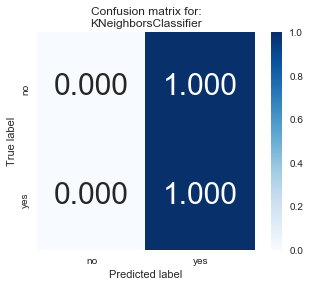

In [32]:
# Testing Heat maps
from sklearn.metrics import confusion_matrix
import seaborn as sns
import matplotlib.pyplot as plt
%matplotlib inline

# clf_A = SVC(random_state=30)
# clf_B = KNeighborsClassifier()
# clf_C = RandomForestClassifier(random_state=30)

# Compute confusion matrix for a model
model = clf_B
cm = confusion_matrix(y_test, model.predict(X_test))
cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis] # normalize the data

# view with a heatmap
sns.heatmap(cm, annot=True, annot_kws={'size':30}, fmt='.3f', cmap='Blues', 
            xticklabels=['no','yes'], yticklabels=['no','yes'], square=True)
plt.ylabel('True label')
plt.xlabel('Predicted label')
plt.title('Confusion matrix for:\n{}'.format(model.__class__.__name__));